# Example of usage Spark OCR for Handwritten Detection

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/handwritten/*"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [2]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# %pip install ../../python/dist/spark-ocr-3.6.0+spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [3]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.6.0



## Read images and display it


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


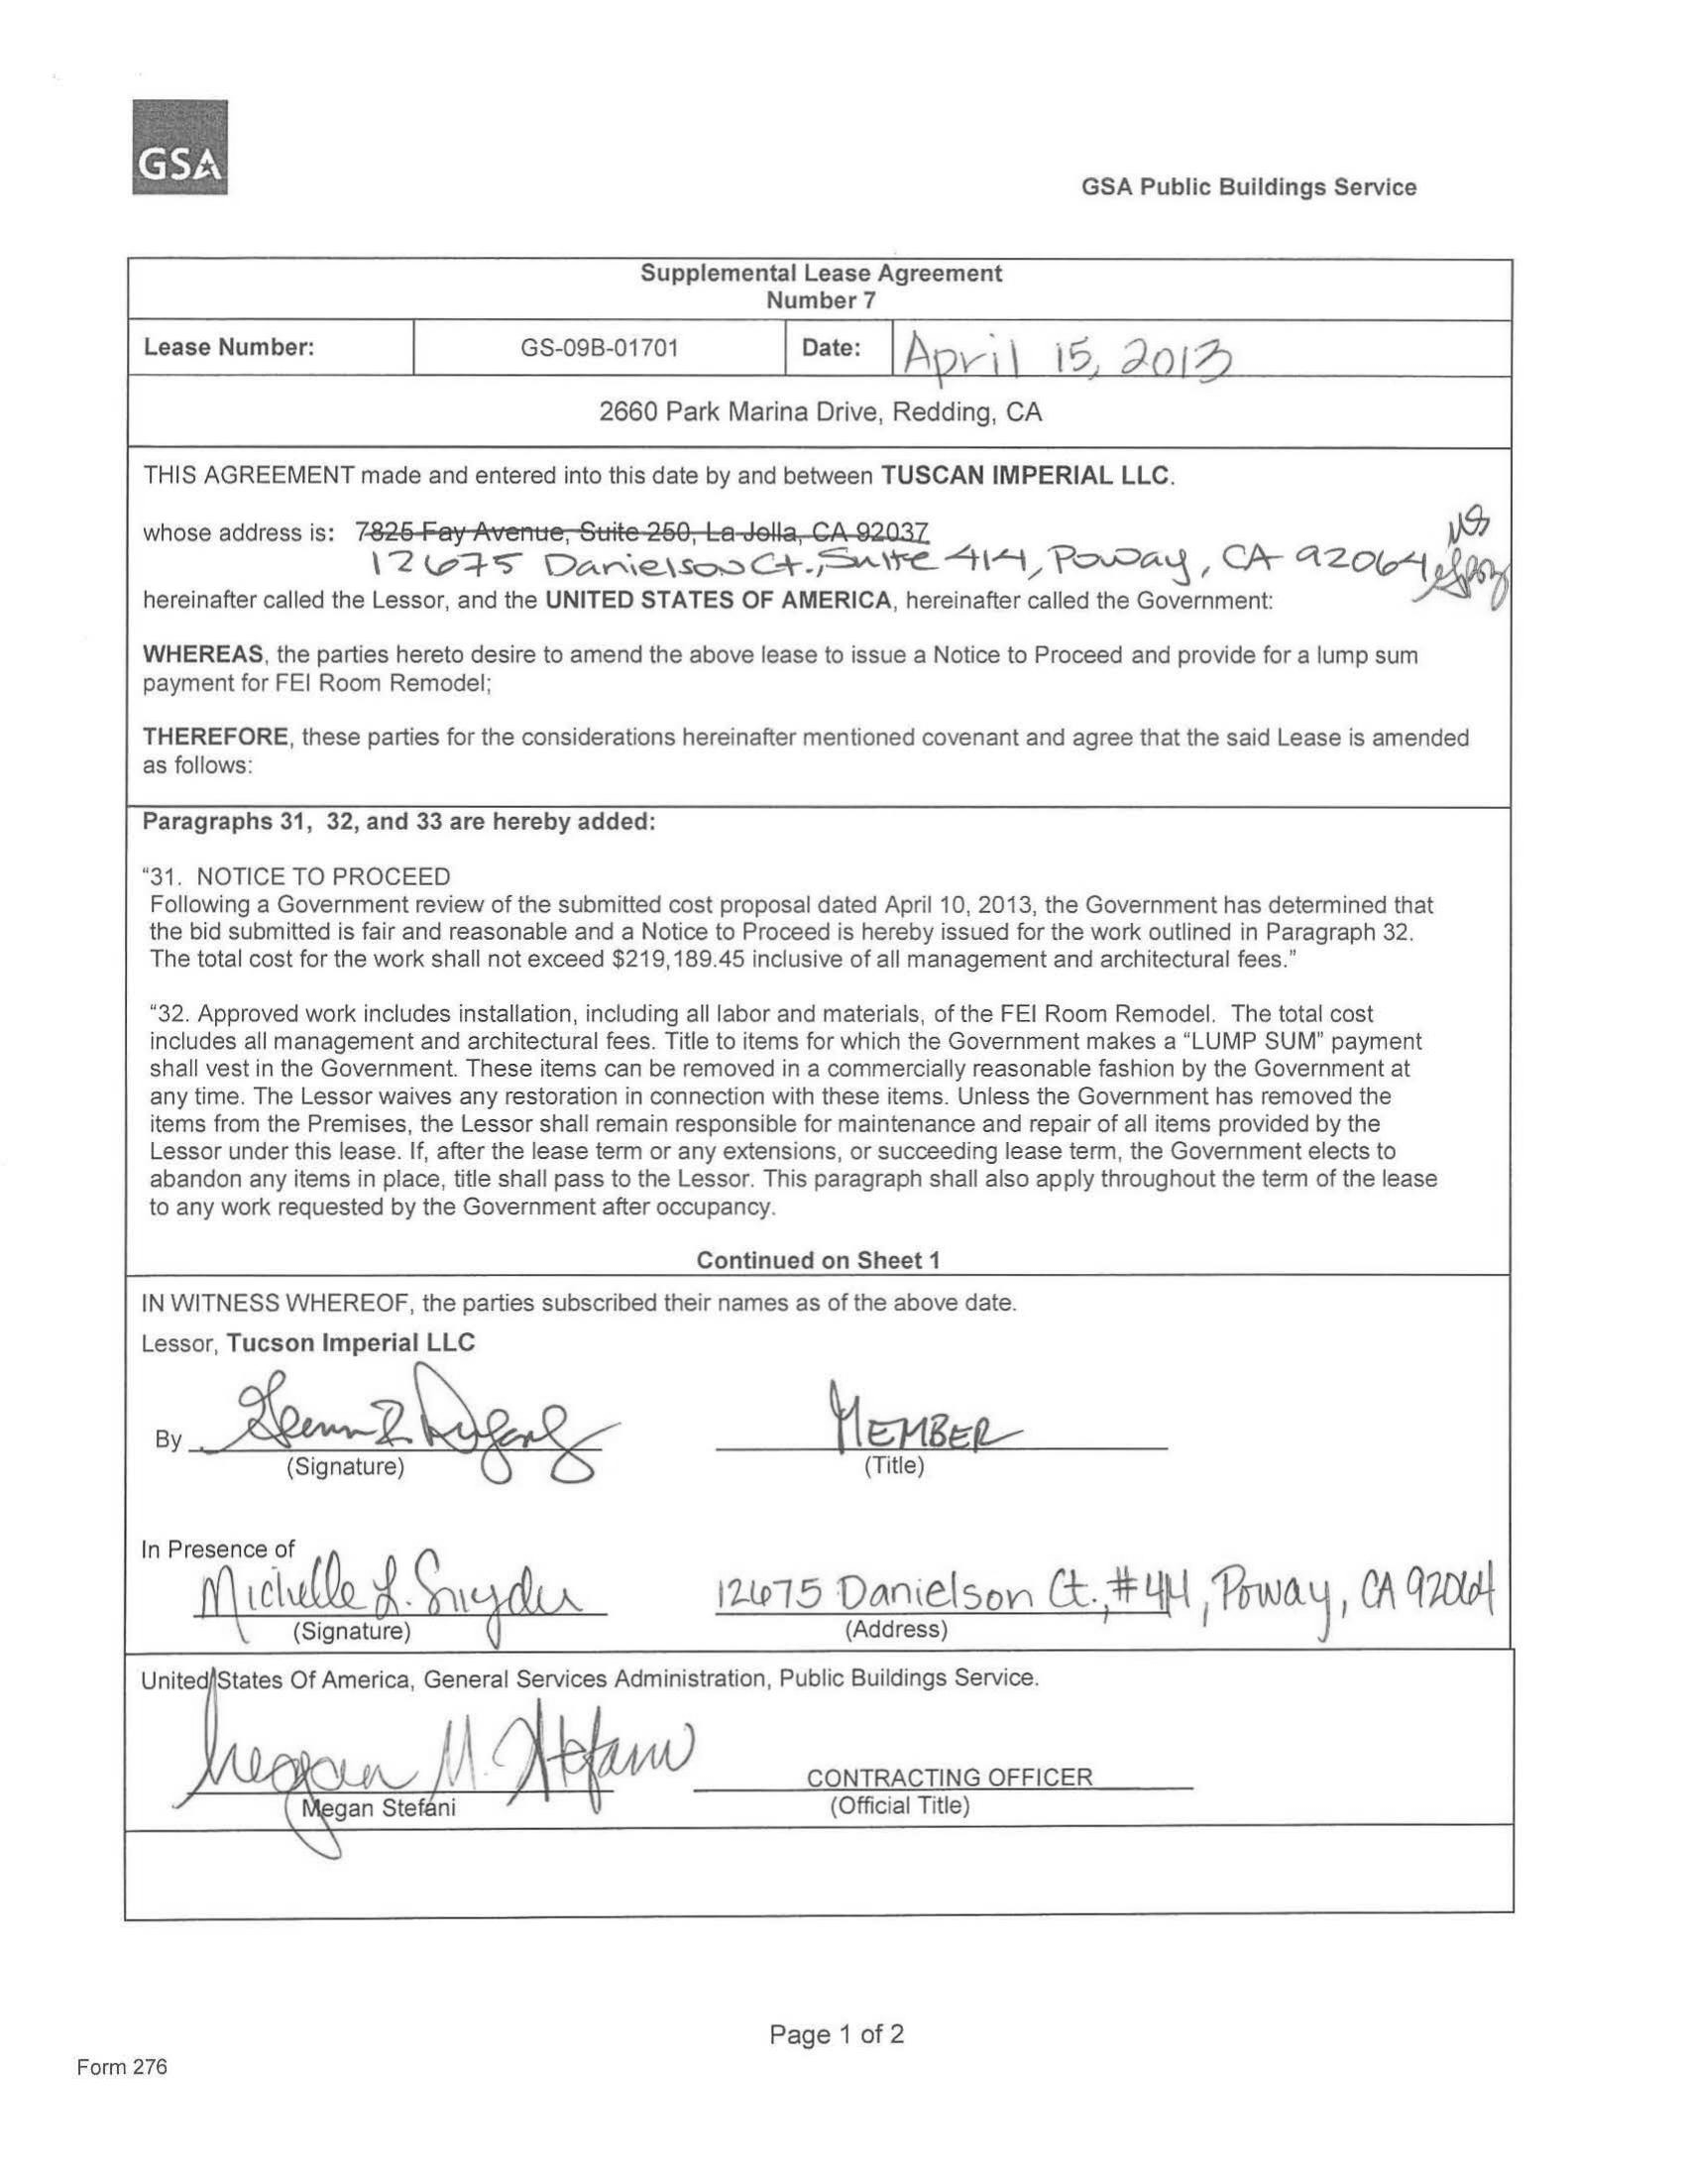

In [4]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [9]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")

handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("handwritten_regions") \
    .setScoreThreshold(0.4)

draw_regions = ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("handwritten_regions") \
   .setOutputCol("image_with_regions") \
   .setFontSize(16) \
   .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    draw_regions
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


In [10]:
handwritten_detector.getLabels()

['signature', 'date', 'name', 'title', 'address', 'others']

## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


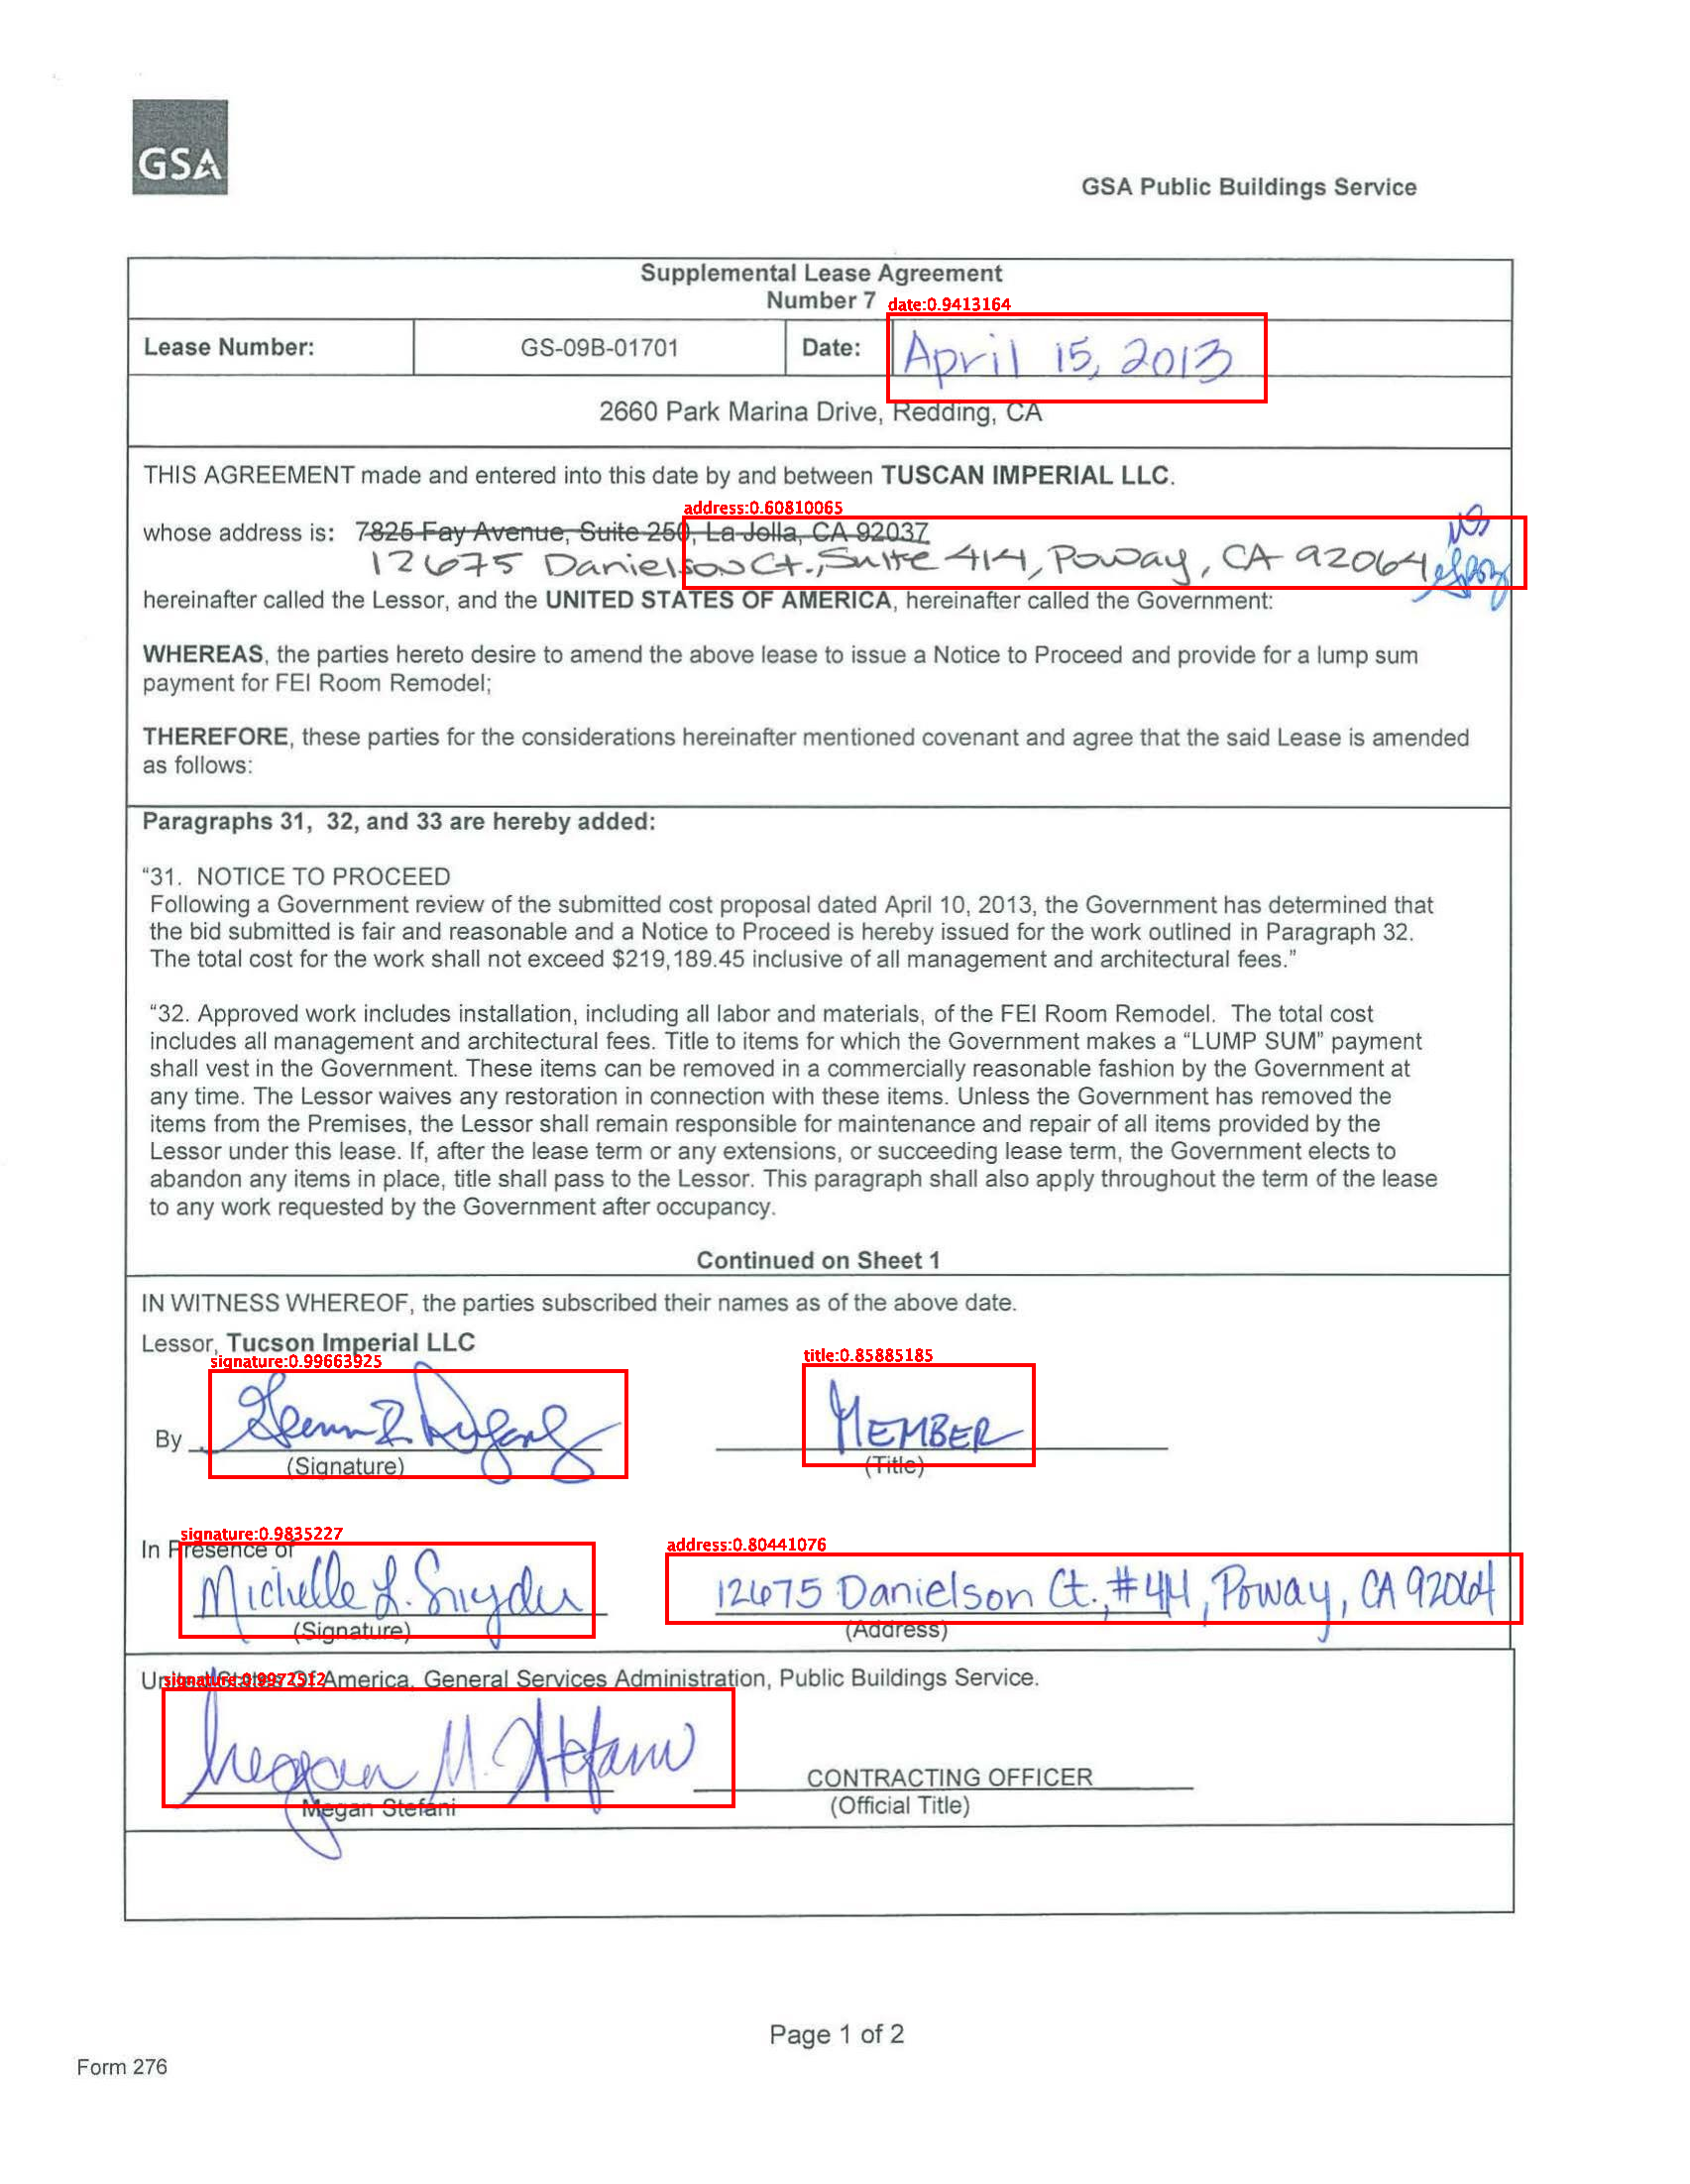

In [11]:
result =  pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

### Output format for regions

In [12]:
result.select("handwritten_regions").printSchema()

root
 |-- handwritten_regions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullable = false)



### Display coordinates and scores of regions

In [13]:
# since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(result['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

result.withColumn("coordinate", f.explode_outer(f.col("handwritten_regions"))) \
    .withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .select("filename", "coordinate") \
    .show(truncate=False)

+----------+----------------------------------------------------------+
|filename  |coordinate                                                |
+----------+----------------------------------------------------------+
|page1.jpeg|[0, 0, 165.0, 1704.0, 575.0, 118.0, 0.9972512, signature] |
|page1.jpeg|[1, 0, 212.0, 1383.0, 420.0, 107.0, 0.99663925, signature]|
|page1.jpeg|[2, 0, 182.0, 1557.0, 417.0, 94.0, 0.9835227, signature]  |
|page1.jpeg|[3, 0, 896.0, 317.0, 381.0, 88.0, 0.9413164, date]        |
|page1.jpeg|[4, 0, 811.0, 1377.0, 232.0, 101.0, 0.85885185, title]    |
|page1.jpeg|[5, 0, 673.0, 1568.0, 862.0, 69.0, 0.80441076, address]   |
|page1.jpeg|[6, 0, 690.0, 522.0, 849.0, 71.0, 0.60810065, address]    |
+----------+----------------------------------------------------------+



In [13]:
assert( result.count() > 0 )